<a href="https://colab.research.google.com/github/mvoicer/cbic-2021-learning-preferences/blob/main/CBIC_2obj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libraries

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import numpy as np
import pandas as pd
import random
import os 
import sys
import seaborn as sns
import pickle
import scipy.stats as stats

from scipy.spatial.distance import cdist
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import *
from tqdm import tqdm
from matplotlib import pyplot as plt

# Directory

In [3]:
from google.colab import drive
drive.mount("/content/drive") 

Mounted at /content/drive


In [4]:
# Set the new directory
os.chdir('/content/drive/My Drive/aa_UFMG/Doutorado/Experimentos GPD/LearningDM/')

print("Current directory {}".format(os.getcwd()))

Current directory /content/drive/My Drive/aa_UFMG/Doutorado/Experimentos GPD/LearningDM


# Dataset

Variables

In [5]:
len_Q = 5                   # n_samples to be evaluated
CV = 5                      # number of cross-validation
test_size = 0.2             # 80% train and 20% test
accepted_error = .05        # max tau distance accepted between current ranking and the predicted one

Dataset

In [6]:
# Decision variables
df_var = pd.read_csv("Data/NSGAIII_GPD03_M2_DEC.CSV", header=None)      # decision variables
# df_var = df_var.iloc[0:100, :].round(5)
df_obj = pd.read_csv('Data/NSGAIII_GPD03_M2_OBJ.CSV', header=None)      # values in Pareto front
# df_obj = df_obj.iloc[0:100, :].round(5)

npop, nvar = df_var.shape
nobj = df_obj.shape[1]

# Functions

## Preference functions

In [7]:
# Define Saaty's 1-9 Scale for AHP Preference
def matrix_intervalos(A):
    max_A = np.max(A, axis=0)
    min_A = np.min(A, axis=0)
    I = np.zeros(shape=(9, len(max_A)))
    for i, (menor, maior) in enumerate(zip(min_A, max_A)):
        intervalos = np.linspace(menor, maior, 9)
        I[:, i] = intervalos.ravel()
    return I

In [8]:
# Calculate the differences among the nominal values of the objectives
def my_cdist(df_obj):
  n_row = df_obj.shape[0]
  m1 = np.tile(df_obj, (n_row, 1))
  m2 = np.tile(df_obj.reshape(-1, 1), (1, n_row))
  return m2 - m1

In [9]:
# Calculate the preferences
def preferencia(df_dif, interval):

    df_pref = np.ones(shape = df_dif.shape)

    it = np.nditer(df_dif, flags=['multi_index'])

    for x in it:
        for j, _ in enumerate(interval):
            if j == len(interval):
                df_pref[it.multi_index] = 9 if x < 0 else 1.0 / 9.0
                break

            if interval[j] <= np.abs(x) <= interval[j + 1]:
                df_pref[it.multi_index] = 1.0 / (j + 1) if x < 0 else j + 1
                break
    return df_pref.round(3)

In [10]:
def notas_pref(A):
  df_pref  = pd.DataFrame()
  I = matrix_intervalos(A)

  # For each objective
  for i, sol in enumerate(A.T):
    # Calculate the difference among the values
    df_dif = my_cdist(sol)
    # Get the intervals
    interval = I[:, i]
    # Generate the PC matrices
    pp = pd.DataFrame(preferencia(df_dif, interval), index = None)

    df_pref = pd.concat([df_pref, pp], axis=1)
    
  return df_pref

## Data preparation

In [11]:
def create_subsample(df_var, df_pref, nobj, index):
  '''
  Create sub-dataframes with the features (alternatives) and target (value in the objective space). 
  '''
  # Create a df_aux that receive the features concatenated (objectives) and targets (preference)
  sub_df = pd.DataFrame(np.zeros((len(index), df_var.shape[1]*2 + nobj)))

  cont = 0
  for i in index:
    for j in index:
      # Concatenate the two rows - i.e. values of the objectives and the preference between the two objectives
      sub_df.loc[cont] = pd.concat([df_var.loc[i], df_var.loc[j], \
                                    df_pref.loc[i, j]], axis = 0, ignore_index = True) 
      cont += 1

  return sub_df

In [12]:
def merge_matrices(idx_N_Q, preference_matrix, ml_predicted, nobj, npop):
    '''
    Replace the predicted values in the preference matrix to calculate 
    if the rankings (predicted vs preference) are equal or not.
    '''
    df_merged = preference_matrix.copy()
    for col in range(nobj):
        row = 0
    for s1 in idx_N_Q:
        for s2 in idx_N_Q:
            df_merged.iloc[s1, s2+npop*col] = ml_predicted.loc[row, col]
            row+= 1
    return df_merged

## Hyper parameters

In [13]:
def fine_tunning(CV, X, y):
    """
    Search the best parameters for the Gradient Boosting Regressor model.
    """
    model = MultiOutputRegressor(GradientBoostingRegressor(loss='ls', 
                                                            learning_rate=0.001, 
                                                            n_estimators=500, 
                                                            subsample=1.0,
                                                            criterion='friedman_mse', 
                                                            min_samples_split=10,
                                                            min_samples_leaf=1,
                                                            min_weight_fraction_leaf=0.0, 
                                                            max_depth=30,
                                                            min_impurity_decrease=0.0,
                                                            min_impurity_split=None, 
                                                            init=None, 
                                                            random_state= 42,
                                                            max_features=None,
                                                            alpha=0.9, 
                                                            verbose=0, 
                                                            max_leaf_nodes=None, 
                                                            warm_start=False,
                                                            validation_fraction=0.1, 
                                                            n_iter_no_change=None, 
                                                            tol=0.0001,
                                                            ccp_alpha=0.0))

    hyperparameters = dict(estimator__learning_rate=[0.05], 
                            estimator__loss=['ls'],
                            estimator__n_estimators=[500, 1000],
                            estimator__criterion=['friedman_mse'], 
                            estimator__min_samples_split=[7, 10],
                            estimator__max_depth=[15, 30], 
                            estimator__min_samples_leaf=[1, 2],
                            estimator__min_impurity_decrease=[0],
                            estimator__max_leaf_nodes=[5, 30])

    randomized_search = RandomizedSearchCV(model, 
                                            hyperparameters, 
                                            random_state=42, 
                                            n_iter=5, 
                                            scoring=None,
                                            n_jobs=-1, 
                                            refit=True, 
                                            cv=CV, 
                                            verbose=True,
                                            pre_dispatch='2*n_jobs', 
                                            error_score='raise', 
                                            return_train_score=True)

    hyperparameters_tuning = randomized_search.fit(X, y)

    tuned_model = hyperparameters_tuning.best_estimator_

    return tuned_model

## Metrics

In [14]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true))

## AHP

In [15]:
# AHP
def ahp(df):
  return ((df / df.apply('sum', axis = 0)).apply("sum", axis = 1)).sort_values(ascending=False)

## Tau distance

In [16]:
# Tau distance
def tau_distance(r1, r2):
  '''
  Values close to 1 indicate strong agreement, 
  and values close to -1 indicate strong disagreement.
  '''
  tau, p_value = stats.kendalltau(r1, r2)
  return tau

def normalised_kendall_tau_distance(r1, r2):
    """
    Compute the normalized Kendall tau distance.
    """
    n = len(r1)
    assert len(r2) == n, "Both lists have to be of equal length"
    i, j = np.meshgrid(np.arange(n), np.arange(n))
    a = np.argsort(r1)
    b = np.argsort(r2)
    ndisordered = np.logical_or(np.logical_and(a[i] < a[j], b[i] > b[j]), np.logical_and(a[i] > a[j], b[i] < b[j])).sum()
    return ndisordered / (n * (n - 1))

# Main 

In [17]:
# Generate the preferences
df_obj = df_obj.to_numpy()
df_pref = notas_pref(df_obj)

# AHP from the original alternatives
rank_ahp = ahp(df_pref).index

In [18]:
# Generate the index to be evaluated
index = list(df_var.index)

# Aleatory ranking
aleatory = index.copy()
random.shuffle(aleatory)

# Start an aleatory ranking
rank_aleatory = aleatory.copy()

  0%|          | 0/39 [00:00<?, ?it/s]

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:   10.8s finished


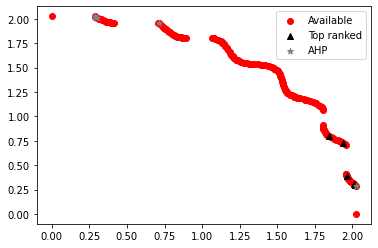

  3%|▎         | 1/39 [03:33<2:15:08, 213.37s/it]

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:   16.3s finished


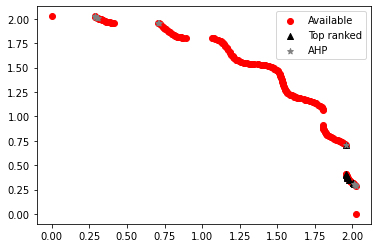

  5%|▌         | 2/39 [07:03<2:10:13, 211.18s/it]

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:   27.9s finished


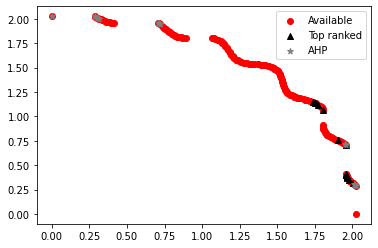

  8%|▊         | 3/39 [10:30<2:05:42, 209.52s/it]

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:   50.7s finished


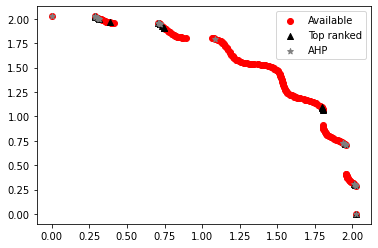

 10%|█         | 4/39 [14:11<2:04:44, 213.85s/it]

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:  1.4min finished


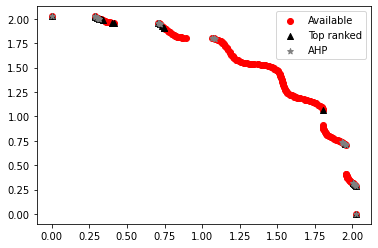

 13%|█▎        | 5/39 [18:16<2:07:41, 225.34s/it]

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:  2.2min finished


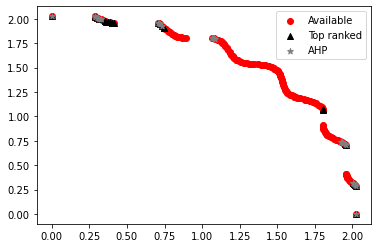

 15%|█▌        | 6/39 [23:01<2:15:04, 245.59s/it]

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:  2.7min finished


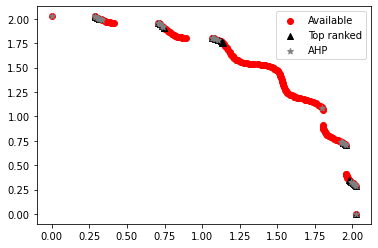

 18%|█▊        | 7/39 [28:07<2:21:28, 265.28s/it]

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:  3.4min finished


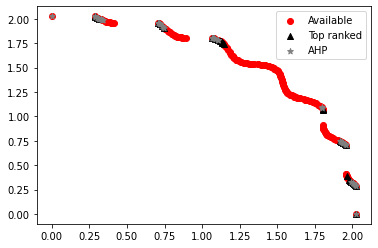

 21%|██        | 8/39 [33:52<2:30:06, 290.55s/it]

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:  4.1min finished


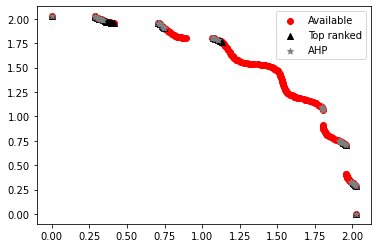

 23%|██▎       | 9/39 [40:12<2:39:15, 318.50s/it]

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:  4.8min finished


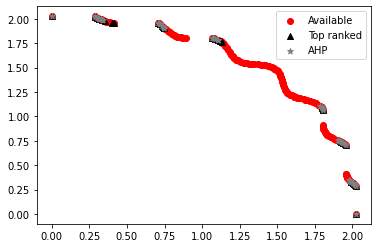

 26%|██▌       | 10/39 [47:40<2:53:23, 358.73s/it]

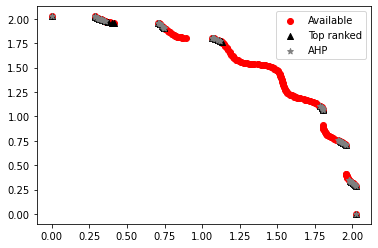

 28%|██▊       | 11/39 [49:19<2:10:16, 279.15s/it]

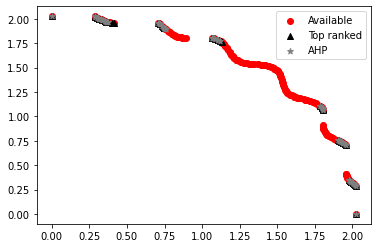

 31%|███       | 12/39 [50:51<1:40:02, 222.30s/it]

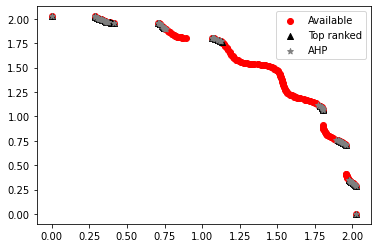

 33%|███▎      | 13/39 [52:20<1:18:44, 181.70s/it]

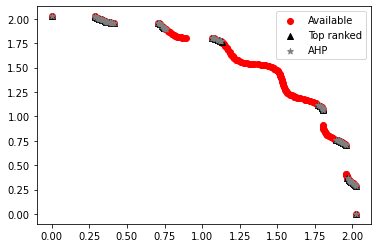

 36%|███▌      | 14/39 [53:41<1:03:06, 151.45s/it]

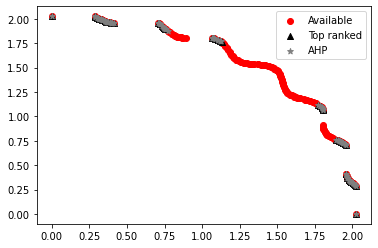

 38%|███▊      | 15/39 [54:59<51:44, 129.35s/it]  

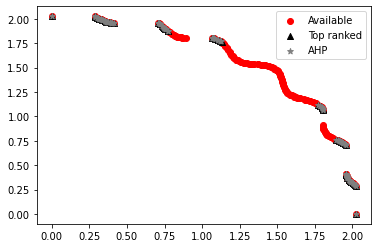

 41%|████      | 16/39 [56:13<43:09, 112.60s/it]

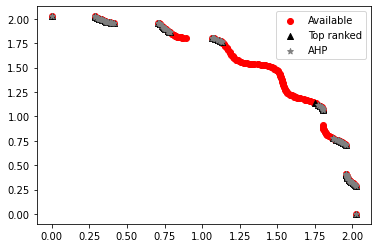

 44%|████▎     | 17/39 [57:26<36:56, 100.73s/it]

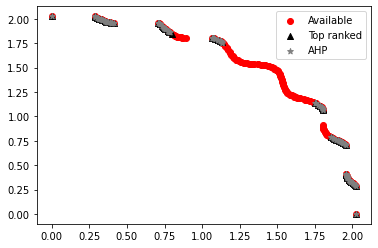

 46%|████▌     | 18/39 [58:36<32:02, 91.53s/it] 

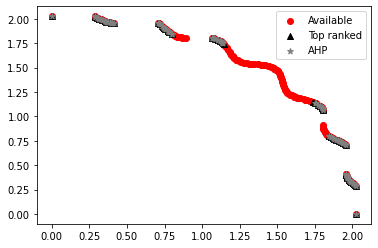

 49%|████▊     | 19/39 [59:46<28:22, 85.12s/it]

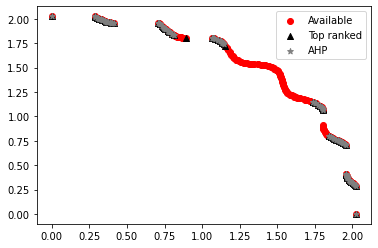

 51%|█████▏    | 20/39 [1:00:55<25:24, 80.24s/it]

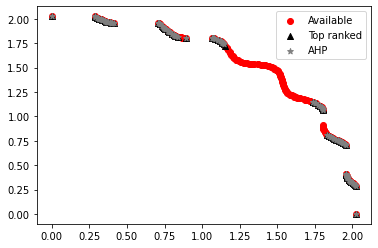

 54%|█████▍    | 21/39 [1:02:06<23:12, 77.34s/it]

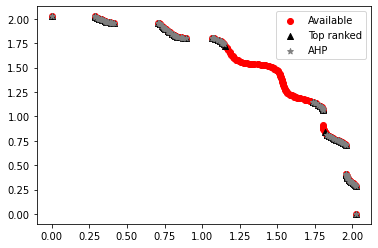

 56%|█████▋    | 22/39 [1:03:14<21:09, 74.67s/it]

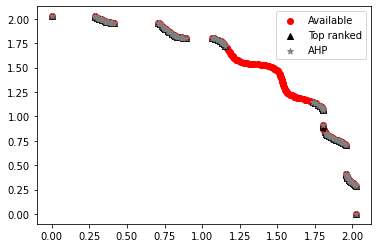

 59%|█████▉    | 23/39 [1:04:26<19:39, 73.69s/it]

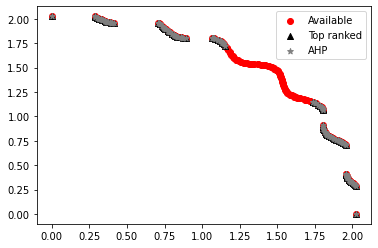

 62%|██████▏   | 24/39 [1:05:39<18:24, 73.64s/it]

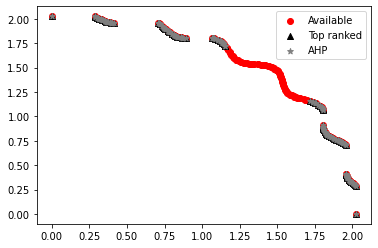

 64%|██████▍   | 25/39 [1:06:55<17:20, 74.31s/it]

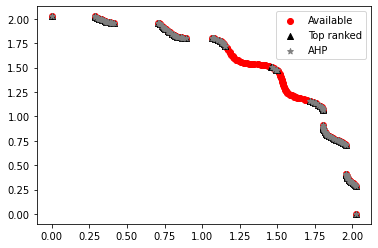

 67%|██████▋   | 26/39 [1:08:15<16:26, 75.90s/it]

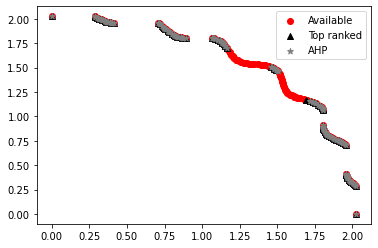

 69%|██████▉   | 27/39 [1:09:42<15:50, 79.24s/it]

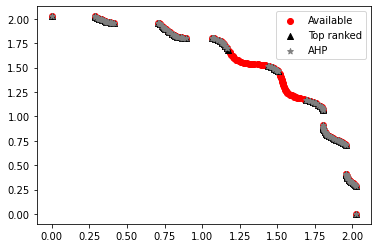

 72%|███████▏  | 28/39 [1:11:16<15:22, 83.84s/it]

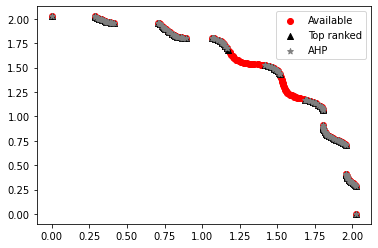

 74%|███████▍  | 29/39 [1:12:54<14:41, 88.11s/it]

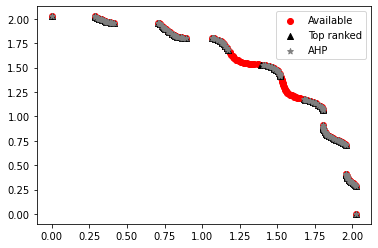

 77%|███████▋  | 30/39 [1:14:37<13:52, 92.48s/it]

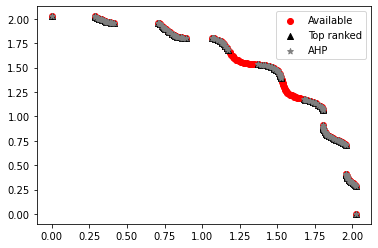

 79%|███████▉  | 31/39 [1:16:29<13:06, 98.26s/it]

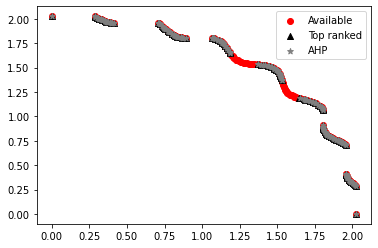

 82%|████████▏ | 32/39 [1:18:31<12:17, 105.32s/it]

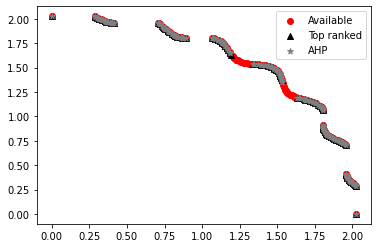

 85%|████████▍ | 33/39 [1:20:42<11:19, 113.23s/it]

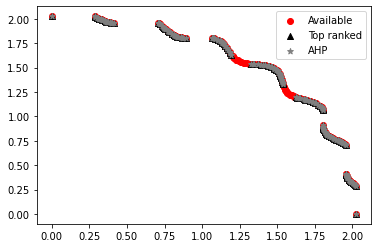

 87%|████████▋ | 34/39 [1:23:15<10:24, 124.99s/it]

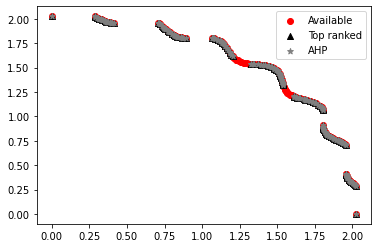

 90%|████████▉ | 35/39 [1:25:55<09:02, 135.58s/it]

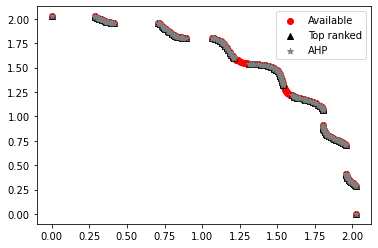

 92%|█████████▏| 36/39 [1:28:41<07:13, 144.60s/it]

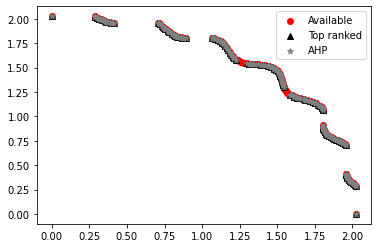

 95%|█████████▍| 37/39 [1:31:41<05:10, 155.21s/it]

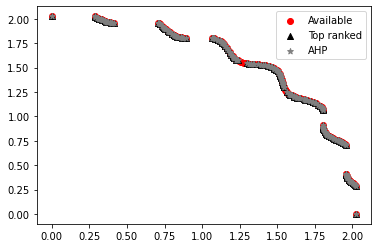

 97%|█████████▋| 38/39 [1:35:02<02:48, 168.90s/it]

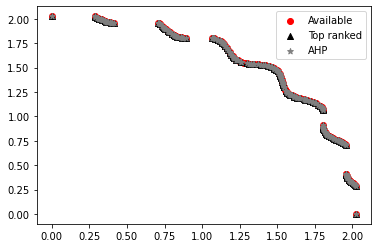

100%|██████████| 39/39 [1:38:25<00:00, 151.43s/it]


In [19]:
# Distancias
current_previous = []
current_ahp = []

# Metrics
mse = []
rmse = []
r2 = []
mape = []

# Iterations
iteration = []
itera = 0

temp = 1
for aux in tqdm(range(len_Q, npop, len_Q)):
    itera += 1

    # Define Q and N-Q indexes
    Q_index = aleatory[0:aux]
    N_Q_index = [x for x in index if x not in Q_index]

    # Train
    df_Q = create_subsample(df_var = df_var, df_pref = df_pref, nobj = nobj, index = Q_index)
    X_train = df_Q.iloc[:,:-nobj]  # to predict
    y_train = df_Q.iloc[:,-nobj:]  # real targets
    # Test
    df_N_Q = create_subsample(df_var = df_var, df_pref = df_pref, nobj = nobj, index = N_Q_index)
    X_test = df_N_Q.iloc[:,:-nobj]  # to predict
    y_test = df_N_Q.iloc[:,-nobj:]  # real targets

    # Model training
    # tuned_model.fit(X_train, y_train)
    # Fine tunning in the 1st iteration
    if temp > accepted_error:
        tuned_model = fine_tunning(CV, X_train, y_train)
        with open("tuned_model_cbic.pkl", 'wb') as arq:      # Save best model
            pickle.dump(tuned_model, arq)
        tuned_model.fit(X_train, y_train)
    else:
        with open("tuned_model_cbic.pkl", "rb") as fp:       # Load trained model
            tuned_model = pickle.load(fp)                        
    # # Model training
    # tuned_model.fit(X_train, y_train)

    # Model evaluation
    y_pred = tuned_model.predict(X_test)
    y_pred = pd.DataFrame(y_pred)

    # Metrics
    mse.append(mean_squared_error(pd.DataFrame(y_test.values), pd.DataFrame(y_pred.values), squared = True))
    rmse.append(mean_squared_error(pd.DataFrame(y_test.values), pd.DataFrame(y_pred.values), squared = False))
    r2.append(r2_score(pd.DataFrame(y_test.values), pd.DataFrame(y_pred.values)))
    mape.append(mean_absolute_percentage_error(pd.DataFrame(y_test.values), pd.DataFrame(y_pred.values)))

    # Merge the predictions of the df train and df test
    df_merged = merge_matrices(N_Q_index, df_pref, y_pred, nobj, npop)

    # Employ AHP in the predicted (mixed with preferences) dataset
    rank_predicted = ahp(df_merged).index

    # Calculate distances
    temp = normalised_kendall_tau_distance(r1 = rank_aleatory, r2 = rank_predicted)
    current_previous.append(temp)
    current_ahp.append(normalised_kendall_tau_distance(r1 = rank_ahp, r2 = rank_predicted))

    df_obj = pd.DataFrame(df_obj)
    plt.scatter(df_obj.loc[:, 0], df_obj.loc[:, 1], color='red')                                                          #available
    plt.scatter(df_obj.loc[rank_predicted[0:aux], 0], df_obj.loc[rank_predicted[0:aux], 1], color='black', marker='^')      #top ranked
    plt.scatter(df_obj.loc[rank_ahp[0:aux], 0], df_obj.loc[rank_ahp[0:aux], 1], color='grey', marker='*')                  #ahp
    plt.legend(["Available","Top ranked", 'AHP'])
    plt.show()

    # Update the ranking
    rank_aleatory = rank_predicted

    # Storage the iterations
    iteration.append(itera)

In [20]:
# Merge the results
results = pd.DataFrame({'Iteration': iteration,
                        'MSE': mse, 
                        'RMSE': rmse, 
                        'R2': r2, 
                        'MAPE': mape,
                        'Current_Previous': current_previous, 
                        'Current_AHP': current_ahp})

results_metrics = results[['Iteration', 'MSE', 'RMSE', 'R2', 'MAPE']]
results_tau = results[['Iteration', 'Current_Previous', 'Current_AHP']]

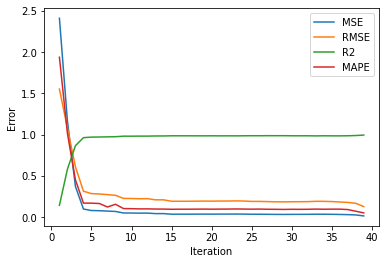

In [21]:
fig, ax = plt.subplots()
sns.lineplot(x = 'Iteration', 
             y = 'value', 
             hue = 'variable', 
             data = pd.melt(results_metrics, "Iteration"))
ax.legend(["MSE", "RMSE", 'R2', 'MAPE'])
plt.ylabel("Error")
plt.show()

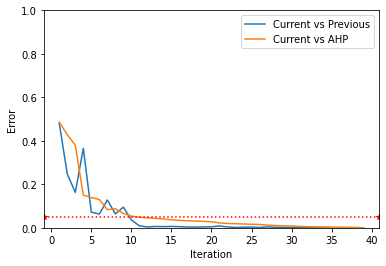

In [22]:
fig, ax = plt.subplots()
sns.lineplot(x = 'Iteration', 
             y = 'value', 
             hue = 'variable', 
             data = pd.melt(results_tau, "Iteration"))
ax.legend(["Current vs Previous", 'Current vs AHP'])
ax.set_ylim(0, 1)
plt.ylabel("Error")
plt.axhline(y=.05, ls=':', color='red', marker='*')
plt.show()

# Select top10 to plot

In [23]:
top10_pred = rank_predicted[0:10]

In [24]:
select_top10 = pd.DataFrame(df_obj)

In [25]:
select_top10 = select_top10.iloc[top10_pred, :]

In [26]:
select_top10.round(4)

,0,1
39,0.2896,2.0228
14,0.2905,2.0220
77,2.0220,0.2905
166,0.3023,2.0117
138,0.7136,1.9544
26,0.7100,1.9557
165,2.0183,0.2950
167,1.9557,0.7100
18,2.0117,0.3024
131,0.3047,2.0097


In [27]:
select_top10.to_csv("cbic_5amostras_2obj.csv", index=None)

# References

- Multiclass and multioutput algorithms -- https://scikit-learn.org/stable/modules/multiclass.html#multioutput-regression
- sklearn.model_selection.RandomizedSearchCV -- https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html
- sklearn.ensemble.GradientBoostingRegressor -- https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html
- sklearn.model_selection.train_test_split -- https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html
- AHP an example -- https://github.com/ani-rudra-chan/AHP-Python-Project/blob/master/ahp.ipynb